In [1]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# 데이터 불러오기
file_path = '/content/drive/MyDrive/Colab Notebooks/final_nba_data_2.csv'
data = pd.read_csv(file_path, encoding='latin1')

# 데이터 확인
data_info = data.info()
data_head = data.head()

data_info, data_head

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1576 non-null   object 
 1   start            1576 non-null   int64  
 2   GS               1576 non-null   float64
 3   MP               1576 non-null   float64
 4   FG               1576 non-null   float64
 5   FGA              1576 non-null   float64
 6   FG%              1576 non-null   float64
 7   3P               1576 non-null   float64
 8   3PA              1576 non-null   float64
 9   3P%              1576 non-null   float64
 10  2P               1576 non-null   float64
 11  2PA              1576 non-null   float64
 12  2P%              1576 non-null   float64
 13  eFG%             1576 non-null   float64
 14  FT               1576 n

(None,
            name  start         GS         MP        FG       FGA       FG%  \
 0   A.J. Lawson   2023   0.000000   7.290196  1.407843  2.917647  0.484275   
 1  Aaron Brooks   2012   9.076271  21.790678  3.694068  9.929661  0.378297   
 2  Aaron Brooks   2013  18.679245  18.783019  2.691509  5.989623  0.446028   
 3  Aaron Brooks   2014  12.768000  20.421200  2.986000  7.197600  0.419640   
 4  Aaron Brooks   2015  12.982301  22.125221  3.564602  8.780973  0.407757   
 
          3P       3PA       3P%  ...    target  Pos           G  Pos_PG  \
 0  0.521569  1.488235  0.334510  ...  0.013971   SG   59.647059   False   
 1  1.194068  4.012712  0.299822  ...  0.057252   PG  118.000000    True   
 2  0.903774  2.531132  0.369425  ...  0.016154   PG  106.000000    True   
 3  1.143600  3.049600  0.380432  ...  0.018167   PG  127.888000    True   
 4  1.385398  3.565044  0.387978  ...  0.032143   PG  121.504425    True   
 
    Pos_SG  Pos_SF  Pos_PF  Pos_C  contract_period  Annual 

In [2]:

# 결측치가 있는 모든 행 제거
data_cleaned = data.dropna()

# Pos 열의 값이 특정 값인 행 제거
positions_to_remove = ['C-PF', 'PF-SF', 'PG-SG', 'SF-SG', 'SG-PG', 'SG-SF']
data_filtered = data_cleaned[~data_cleaned['Pos'].isin(positions_to_remove)]
data_filtered = data_filtered.drop(columns=['Pos'])
# 원-핫 인코딩된 열만 선택하여 int로 변환
encoded_columns = [col for col in data_filtered.columns if col.startswith('Pos_')]
data_filtered[encoded_columns] = data_filtered[encoded_columns].astype(int)

# 결과 데이터 확인
data_filtered.head()
data_encoded = data_filtered

# target feature (목표 변수)
target = data_encoded['target']

# input feature (입력 변수들)
input_features = data_encoded.drop(columns=['name', 'target', 'salary', 'contract_period'])

# 결과 데이터 확인
input_features.head()


,start,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,debut,end,birth,G,Pos_PG,Pos_SG,Pos_SF,Pos_PF,Pos_C,Annual
0,2023,0.000000,7.290196,1.407843,2.917647,0.484275,0.521569,1.488235,0.334510,0.886275,...,2021,2026,2000,59.647059,0,1,0,0,0,3
1,2012,9.076271,21.790678,3.694068,9.929661,0.378297,1.194068,4.012712,0.299822,2.521186,...,2007,2013,1985,118.000000,1,0,0,0,0,6
2,2013,18.679245,18.783019,2.691509,5.989623,0.446028,0.903774,2.531132,0.369425,1.787736,...,2007,2013,1985,106.000000,1,0,0,0,0,7
3,2014,12.768000,20.421200,2.986000,7.197600,0.419640,1.143600,3.049600,0.380432,1.859600,...,2007,2014,1985,127.888000,1,0,0,0,0,8
4,2015,12.982301,22.125221,3.564602,8.780973,0.407757,1.385398,3.565044,0.387978,2.198230,...,2007,2015,1985,121.504425,1,0,0,0,0,9


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# 데이터셋을 학습용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.3, random_state=42)

# 특징 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost 모델
xgb_model = XGBRegressor(random_state=42)

# XGBoost 하이퍼파라미터 그리드
xgb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'reg_alpha': [0, 0.1],  # L1 규제
    'reg_lambda': [1, 1.5]  # L2 규제
}

# AdaBoost 모델
ada_model = AdaBoostRegressor(random_state=42)

# AdaBoost 하이퍼파라미터 그리드
ada_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1]
}

# GridSearchCV 설정
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid,
                               scoring='r2', cv=3, n_jobs=-1, verbose=1)

ada_grid_search = GridSearchCV(estimator=ada_model, param_grid=ada_param_grid,
                               scoring='r2', cv=3, n_jobs=-1, verbose=1)

# 그리드 서치를 통해 모델 학습
xgb_grid_search.fit(X_train_scaled, y_train)
ada_grid_search.fit(X_train_scaled, y_train)

# 최적의 모델 추출
best_xgb_model = xgb_grid_search.best_estimator_
best_ada_model = ada_grid_search.best_estimator_

# 최적의 XGBoost 모델에 조기 종료 적용
best_xgb_model.fit(X_train_scaled, y_train,
                   early_stopping_rounds=10,
                   eval_set=[(X_test_scaled, y_test)],
                   verbose=False)

# 모델 평가
xgb_train_pred = best_xgb_model.predict(X_train_scaled)
xgb_test_pred = best_xgb_model.predict(X_test_scaled)
ada_train_pred = best_ada_model.predict(X_train_scaled)
ada_test_pred = best_ada_model.predict(X_test_scaled)

# R² 점수 계산
xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)
ada_train_r2 = r2_score(y_train, ada_train_pred)
ada_test_r2 = r2_score(y_test, ada_test_pred)

print(f'XGBoost Train R²: {xgb_train_r2}')
print(f'XGBoost Test R²: {xgb_test_r2}')
print(f'AdaBoost Train R²: {ada_train_r2}')
print(f'AdaBoost Test R²: {ada_test_r2}')


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost Train R²: 0.9195981486804433
XGBoost Test R²: 0.7114018529491634
AdaBoost Train R²: 0.7564039758808716
AdaBoost Test R²: 0.5782233829048755


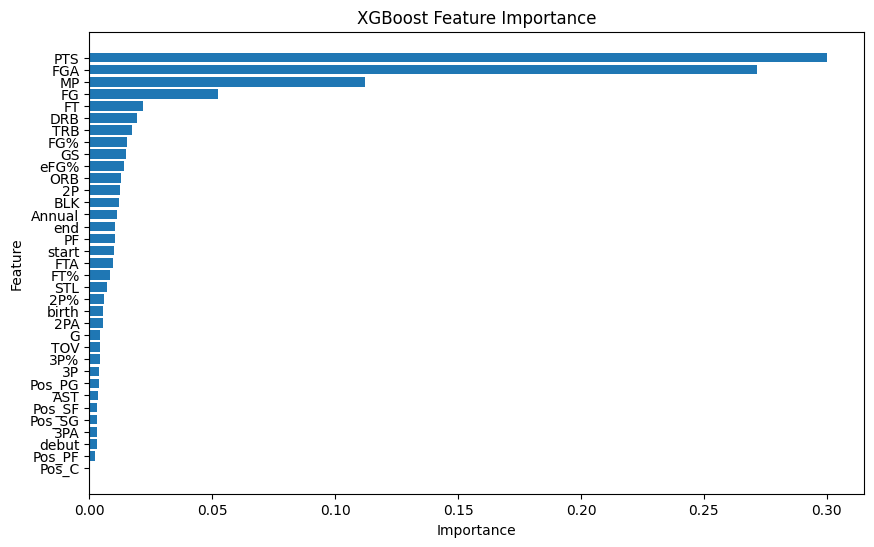

In [4]:
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
import xgboost as xgb
from xgboost import plot_importance, plot_tree

feature_names = X_train_scaled.columns if hasattr(X_train_scaled, 'columns') else [f'feature_{i}' for i in range(X_train_scaled.shape[1])]
feature_importances = best_xgb_model.feature_importances_
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y axis to have the most important feature on top
plt.show()

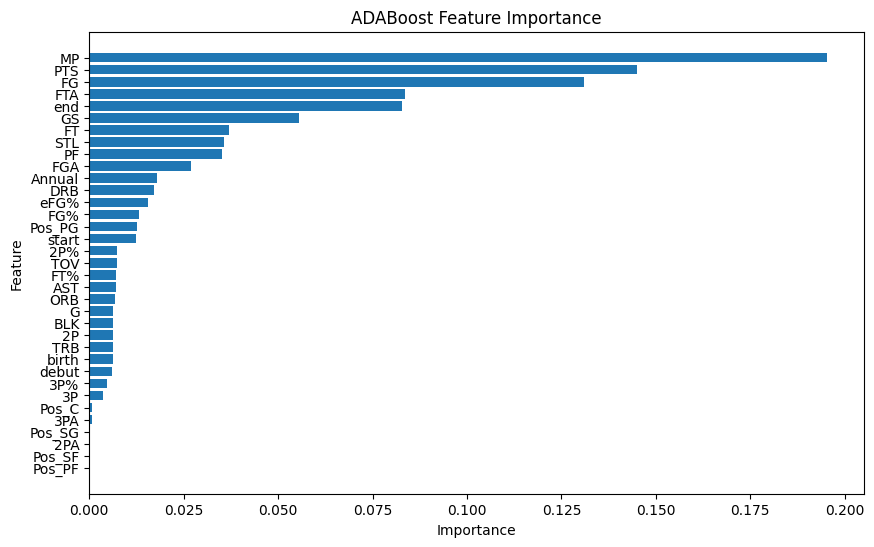

In [5]:
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
import xgboost as xgb
from xgboost import plot_importance, plot_tree

feature_names = X_train_scaled.columns if hasattr(X_train_scaled, 'columns') else [f'feature_{i}' for i in range(X_train_scaled.shape[1])]
feature_importances = best_ada_model.feature_importances_
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('ADABoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y axis to have the most important feature on top
plt.show()

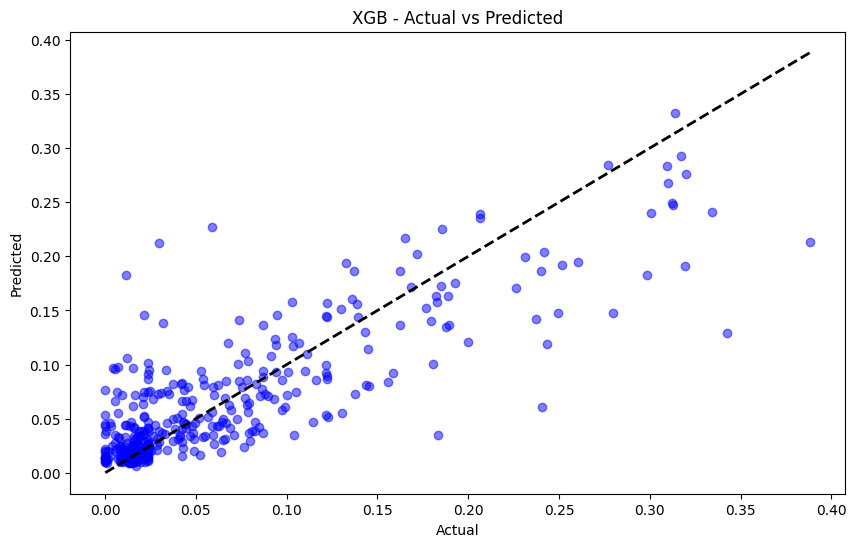

In [6]:
 # 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGB - Actual vs Predicted')
plt.show()

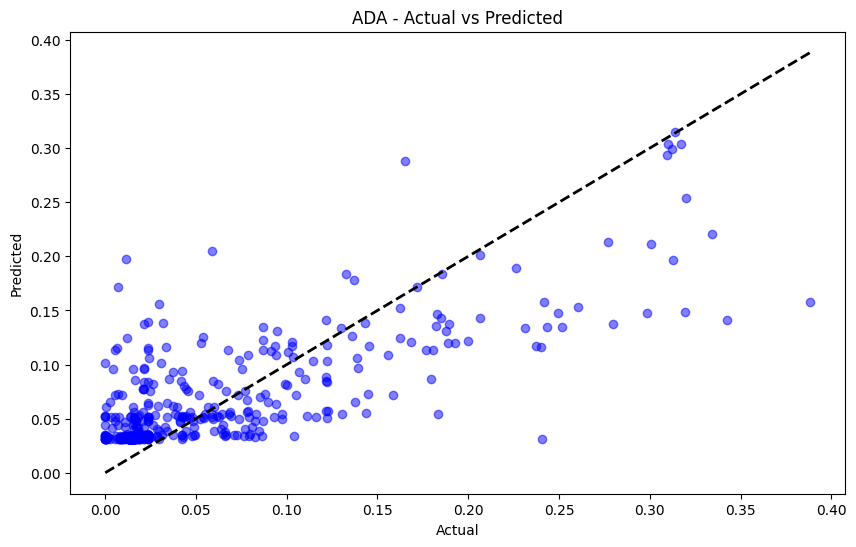

In [7]:
 # 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ada_test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('ADA - Actual vs Predicted')
plt.show()